In [1]:
# Import necessary libraries
import mne
import yasa
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, cohen_kappa_score
import matplotlib.pyplot as plt
import seaborn as sns
import os

# Configure matplotlib for better visuals
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.2)


In [2]:
def calculate_n3_statistics(conf_mat, labels):
    """
    Calculate statistical measures for N3 stage.

    Parameters:
    - conf_mat: Confusion matrix.
    - labels: List of labels.

    Returns:
    - n3_stats: Dictionary with statistical measures for N3.
    """
    n3_index = labels.index('N3')
    TP = conf_mat[n3_index, n3_index]
    FN = conf_mat[n3_index, :].sum() - TP
    FP = conf_mat[:, n3_index].sum() - TP
    TN = conf_mat.sum() - (TP + FN + FP)

    sensitivity = TP / (TP + FN) if (TP + FN) > 0 else 0
    specificity = TN / (TN + FP) if (TN + FP) > 0 else 0
    precision = TP / (TP + FP) if (TP + FP) > 0 else 0
    f1_score = 2 * TP / (2 * TP + FP + FN) if (2 * TP + FP + FN) > 0 else 0

    n3_stats = {
        'Sensitivity (Recall)': sensitivity,
        'Specificity': specificity,
        'Precision': precision,
        'F1-Score': f1_score
    }

    return n3_stats



In [3]:
from statsmodels.stats.inter_rater import cohens_kappa

import numpy as np
from statsmodels.stats.inter_rater import cohens_kappa
import scipy.stats as stats
import pandas as pd

def kappa_with_confidence(hypno_ref, hypno_pred, labels=None, num_bootstrap=1000, conf_level=0.95):
    if labels is None:
        labels = sorted(set(hypno_ref) | set(hypno_pred))  # union of unique labels in both arrays
    
    kappa_values = []
    
    for _ in range(num_bootstrap):
        indices = np.random.choice(len(hypno_ref), size=len(hypno_ref), replace=True)
        bootstrap_ref = hypno_ref[indices]
        bootstrap_pred = hypno_pred[indices]
        
        # Create a cross-tabulation table with all labels
        table = pd.crosstab(pd.Categorical(bootstrap_ref, categories=labels),
                            pd.Categorical(bootstrap_pred, categories=labels), 
                            dropna=False)
        
        kappa_result = cohens_kappa(table)
        kappa_values.append(kappa_result.kappa)
    
    # Calculate the original kappa with full label alignment
    original_table = pd.crosstab(pd.Categorical(hypno_ref, categories=labels),
                                 pd.Categorical(hypno_pred, categories=labels), 
                                 dropna=False)
    original_kappa = cohens_kappa(original_table).kappa

    lower_bound = np.percentile(kappa_values, (1 - conf_level) / 2 * 100)
    upper_bound = np.percentile(kappa_values, (1 + conf_level) / 2 * 100)
    kappa_ci = (lower_bound, upper_bound)
    
    return original_kappa, kappa_ci




In [4]:
# Import necessary libraries
import mne
import yasa
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, cohen_kappa_score
import matplotlib.pyplot as plt
import seaborn as sns
import os

# For statistical analysis
from statsmodels.stats.inter_rater import cohens_kappa

# Configure matplotlib for better visuals
%matplotlib inline
sns.set(style='whitegrid', palette='muted', font_scale=1.2)


In [5]:
def load_annotations(file_path):
    """
    Load sleep stage annotations from a text file.

    Parameters:
    - file_path: Path to the annotations file.

    Returns:
    - hypno_ref: NumPy array of integer sleep stages.
    """
    annotations = pd.read_csv(file_path)
    # Ensure the correct column names
    if ' Annotation' in annotations.columns:
        annotation_col = ' Annotation'
    elif 'Annotation' in annotations.columns:
        annotation_col = 'Annotation'
    else:
        raise ValueError('Annotation column not found in the annotations file.')

    # Filter to include only sleep stage annotations
    annotations = annotations[annotations[annotation_col].str.contains('Sleep stage')].reset_index(drop=True)

    # Extract sleep stage labels from the 'Annotation' column
    def extract_stage(s):
        return s.split()[-1]

    annotations['Stage'] = annotations[annotation_col].apply(extract_stage)

    # Map sleep stages to integer labels
    stage_dict = {'W': 0, 'N1': 1, 'N2': 2, 'N3': 3, 'R': 4}
    annotations['Stage_int'] = annotations['Stage'].map(stage_dict)

    # Extract the integer sleep stages as a NumPy array
    hypno_ref = annotations['Stage_int'].values

    return hypno_ref


def predict_sleep_stages(raw):
    """
    Predict sleep stages using YASA.

    Parameters:
    - raw: MNE Raw object containing PSG data.

    Returns:
    - hypno_pred_int: NumPy array of predicted integer sleep stages.
    """
    # Use YASA to predict sleep stages
    sls = yasa.SleepStaging(
        raw,
        eeg_name='EEG C4-M1',    # EEG channel
        eog_name='EOG E1-M2',    # EOG channel
        emg_name='EMG chin'      # EMG channel
    )

    # Predict sleep stages
    hypno_pred = sls.predict()  # Predicted sleep stages as strings

    # Convert predicted sleep stages to integer labels
    hypno_pred_int = yasa.hypno_str_to_int(hypno_pred)

    return hypno_pred_int


def perform_analysis(hypno_ref, hypno_pred_int, dataset_name):
    """
    Perform accuracy analysis and generate plots.

    Parameters:
    - hypno_ref: Reference hypnogram (annotations).
    - hypno_pred_int: Predicted hypnogram.
    - dataset_name: Name of the dataset (e.g., 'SN001').

    Returns:
    - accuracy: Overall accuracy.
    - kappa: Cohen's Kappa statistic.
    - n3_accuracy: Accuracy for N3 stage.
    """
    # Align the lengths
    len_ref = len(hypno_ref)
    len_pred = len(hypno_pred_int)

    if len_pred > len_ref:
        hypno_pred_int = hypno_pred_int[:len_ref]
    elif len_ref > len_pred:
        hypno_ref = hypno_ref[:len_pred]

    # Calculate overall accuracy
    accuracy = accuracy_score(hypno_ref, hypno_pred_int)
    print(f'\nDataset: {dataset_name}')
    print(f'Overall Accuracy: {accuracy * 100:.2f}%')

    # Generate the confusion matrix
    conf_mat = confusion_matrix(hypno_ref, hypno_pred_int, labels=[0, 1, 2, 3, 4])

    # Define labels for sleep stages
    labels = ['W', 'N1', 'N2', 'N3', 'REM']

    # Plot the confusion matrix
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues',
                xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Sleep Stage')
    plt.ylabel('True Sleep Stage')
    plt.title(f'Confusion Matrix - {dataset_name}')
    plt.show()

    # Print the classification report
    report = classification_report(hypno_ref, hypno_pred_int, target_names=labels, zero_division=0)
    print('Classification Report:')
    print(report)

    # Calculate Cohen's Kappa
    kappa = cohen_kappa_score(hypno_ref, hypno_pred_int)
    print(f"Cohen's Kappa: {kappa:.3f}")

    # Plot the reference and predicted hypnograms
    plt.figure(figsize=(15, 5))
    plt.plot(hypno_ref, label='Reference Hypnogram')
    plt.plot(hypno_pred_int, label='Predicted Hypnogram', alpha=0.7)
    plt.legend()
    plt.xlabel('Epochs (30 seconds per epoch)')
    plt.ylabel('Sleep Stage')
    plt.title(f'Comparison of Hypnograms - {dataset_name}')
    plt.yticks(ticks=[0, 1, 2, 3, 4], labels=labels)
    plt.show()

    # Calculate accuracy for each sleep stage
    per_class_accuracy = conf_mat.diagonal() / conf_mat.sum(axis=1)
    print(f'\nAccuracy per Sleep Stage:')
    for i, stage in enumerate(labels):
        print(f'Accuracy for {stage}: {per_class_accuracy[i] * 100:.2f}%')

    # Extract N3 accuracy
    n3_index = labels.index('N3')
    n3_accuracy = per_class_accuracy[n3_index]

    # Calculate N3 statistical measures
    n3_stats = calculate_n3_statistics(conf_mat, labels)
    print(f"\nN3 Stage Statistical Measures:")
    for metric, value in n3_stats.items():
        print(f"{metric}: {value * 100:.2f}%")

    return accuracy, kappa, n3_accuracy, conf_mat, labels



Extracting EDF parameters from /home/santiago/Desktop/BCI_UNL_AllisonPeterson_course-main/final_course_project/data/SN001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6566399  =      0.000 ... 25649.996 secs...


/tmp/ipykernel_235677/3500611535.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
/tmp/ipykernel_235677/3500611535.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
/home/santiago/Desktop/BCI_UNL_AllisonPeterson_course-main/final_course_project/.venv/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(



Dataset: SN001
Overall Accuracy: 81.26%


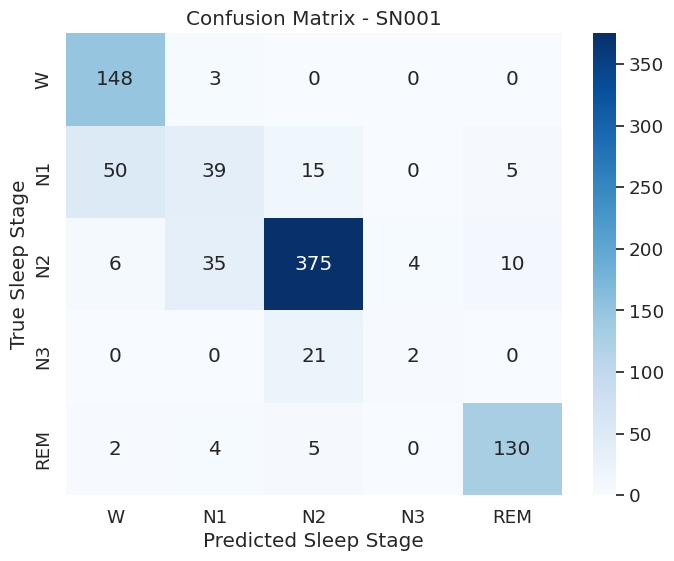

Classification Report:
              precision    recall  f1-score   support

           W       0.72      0.98      0.83       151
          N1       0.48      0.36      0.41       109
          N2       0.90      0.87      0.89       430
          N3       0.33      0.09      0.14        23
         REM       0.90      0.92      0.91       141

    accuracy                           0.81       854
   macro avg       0.67      0.64      0.63       854
weighted avg       0.80      0.81      0.80       854

Cohen's Kappa: 0.721


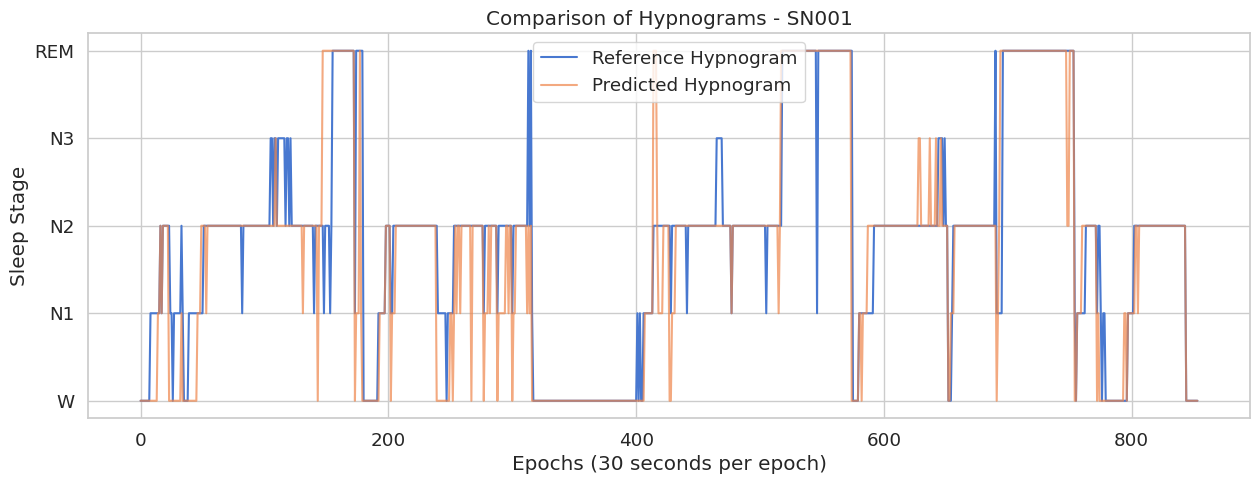


Accuracy per Sleep Stage:
Accuracy for W: 98.01%
Accuracy for N1: 35.78%
Accuracy for N2: 87.21%
Accuracy for N3: 8.70%
Accuracy for REM: 92.20%

N3 Stage Statistical Measures:
Sensitivity (Recall): 8.70%
Specificity: 99.52%
Precision: 33.33%
F1-Score: 13.79%
Extracting EDF parameters from /home/santiago/Desktop/BCI_UNL_AllisonPeterson_course-main/final_course_project/data/SN002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6577407  =      0.000 ... 25692.996 secs...


/tmp/ipykernel_235677/3500611535.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
/tmp/ipykernel_235677/3500611535.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
/home/santiago/Desktop/BCI_UNL_AllisonPeterson_course-main/final_course_project/.venv/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(



Dataset: SN002
Overall Accuracy: 80.14%


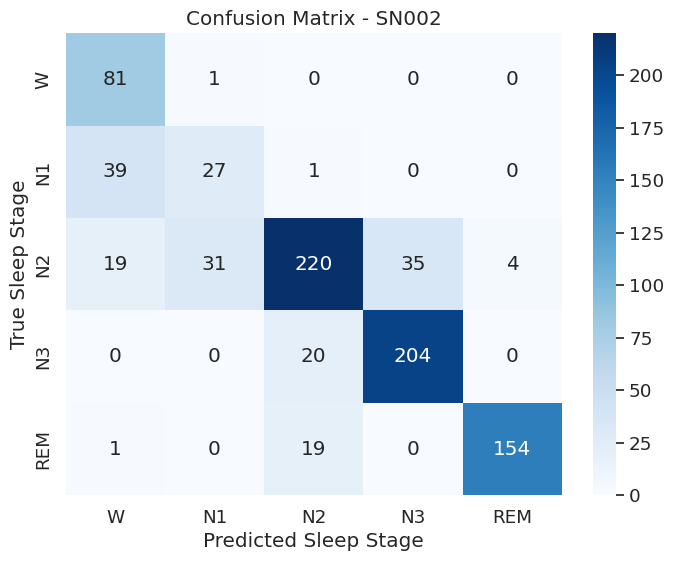

Classification Report:
              precision    recall  f1-score   support

           W       0.58      0.99      0.73        82
          N1       0.46      0.40      0.43        67
          N2       0.85      0.71      0.77       309
          N3       0.85      0.91      0.88       224
         REM       0.97      0.89      0.93       174

    accuracy                           0.80       856
   macro avg       0.74      0.78      0.75       856
weighted avg       0.82      0.80      0.80       856

Cohen's Kappa: 0.738


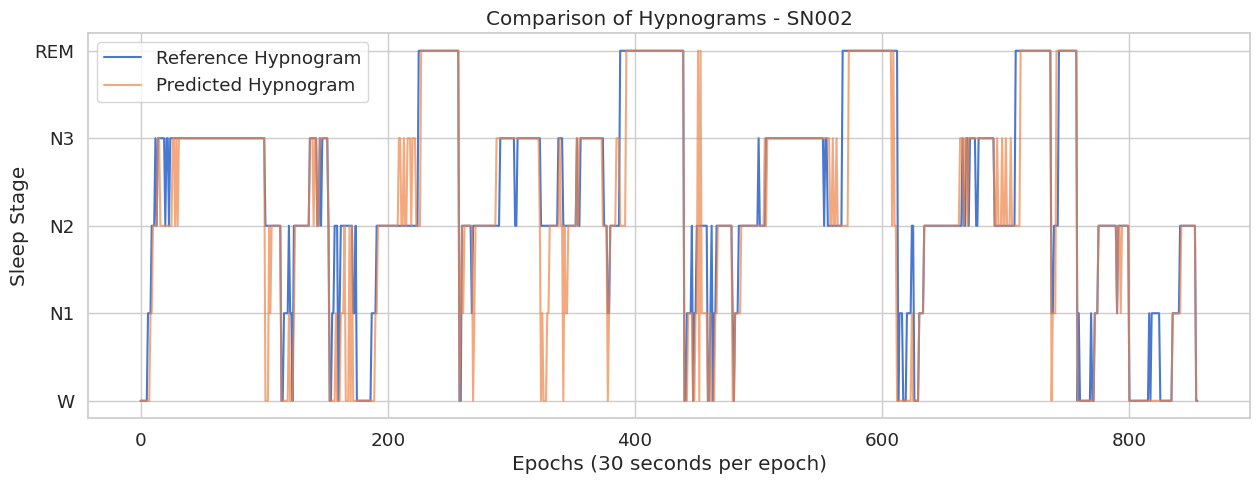


Accuracy per Sleep Stage:
Accuracy for W: 98.78%
Accuracy for N1: 40.30%
Accuracy for N2: 71.20%
Accuracy for N3: 91.07%
Accuracy for REM: 88.51%

N3 Stage Statistical Measures:
Sensitivity (Recall): 91.07%
Specificity: 94.46%
Precision: 85.36%
F1-Score: 88.12%
Extracting EDF parameters from /home/santiago/Desktop/BCI_UNL_AllisonPeterson_course-main/final_course_project/data/SN003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7330815  =      0.000 ... 28635.996 secs...


/tmp/ipykernel_235677/3500611535.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
/tmp/ipykernel_235677/3500611535.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
/home/santiago/Desktop/BCI_UNL_AllisonPeterson_course-main/final_course_project/.venv/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(



Dataset: SN003
Overall Accuracy: 73.48%


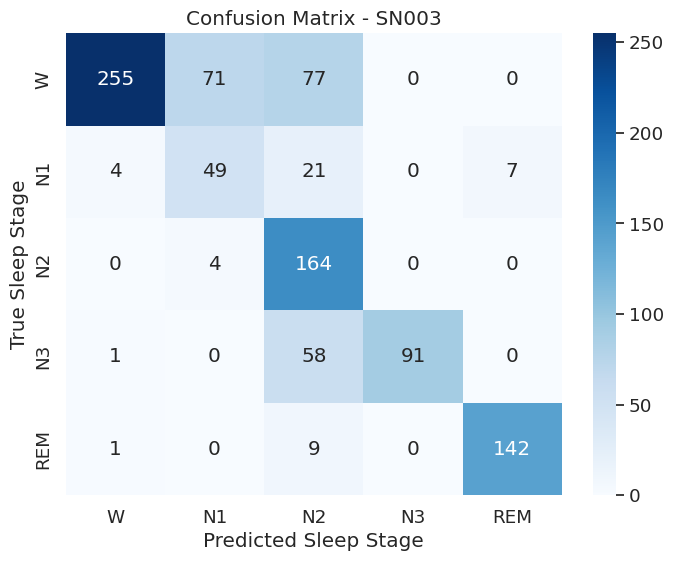

Classification Report:
              precision    recall  f1-score   support

           W       0.98      0.63      0.77       403
          N1       0.40      0.60      0.48        81
          N2       0.50      0.98      0.66       168
          N3       1.00      0.61      0.76       150
         REM       0.95      0.93      0.94       152

    accuracy                           0.73       954
   macro avg       0.76      0.75      0.72       954
weighted avg       0.84      0.73      0.75       954

Cohen's Kappa: 0.657


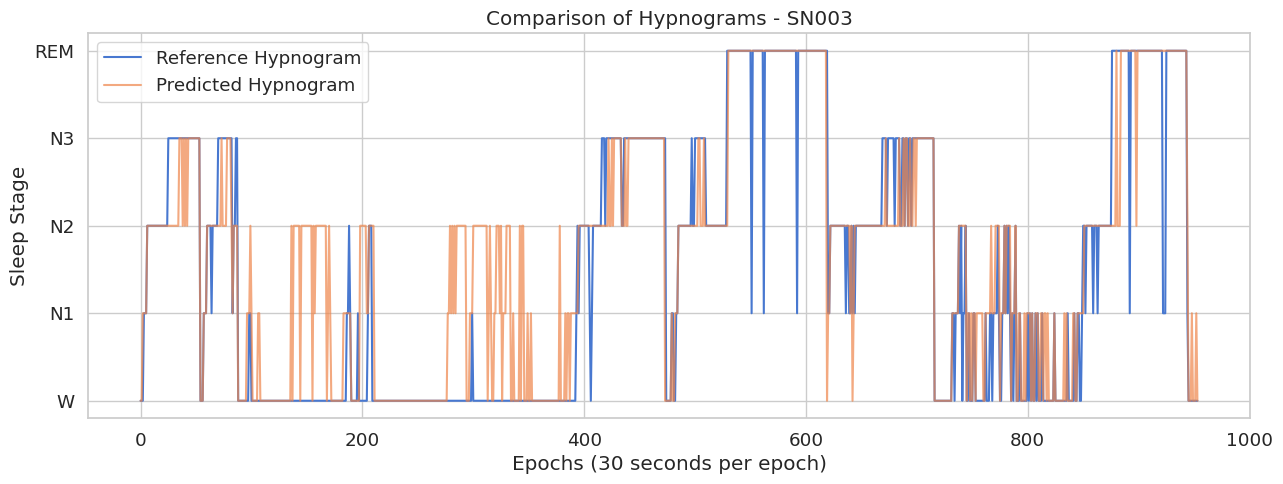


Accuracy per Sleep Stage:
Accuracy for W: 63.28%
Accuracy for N1: 60.49%
Accuracy for N2: 97.62%
Accuracy for N3: 60.67%
Accuracy for REM: 93.42%

N3 Stage Statistical Measures:
Sensitivity (Recall): 60.67%
Specificity: 100.00%
Precision: 100.00%
F1-Score: 75.52%
Extracting EDF parameters from /home/santiago/Desktop/BCI_UNL_AllisonPeterson_course-main/final_course_project/data/SN006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6655487  =      0.000 ... 25997.996 secs...


/tmp/ipykernel_235677/3500611535.py:29: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
/tmp/ipykernel_235677/3500611535.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
/home/santiago/Desktop/BCI_UNL_AllisonPeterson_course-main/final_course_project/.venv/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(



Dataset: SN006
Overall Accuracy: 78.41%


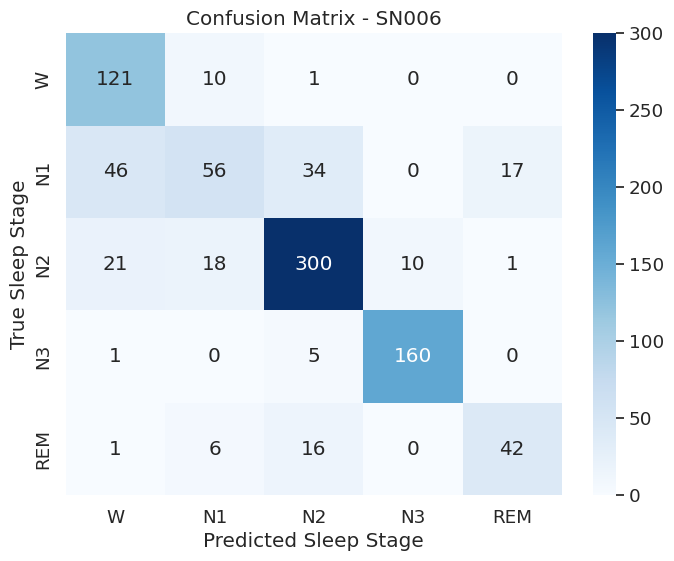

Classification Report:
              precision    recall  f1-score   support

           W       0.64      0.92      0.75       132
          N1       0.62      0.37      0.46       153
          N2       0.84      0.86      0.85       350
          N3       0.94      0.96      0.95       166
         REM       0.70      0.65      0.67        65

    accuracy                           0.78       866
   macro avg       0.75      0.75      0.74       866
weighted avg       0.78      0.78      0.77       866

Cohen's Kappa: 0.708


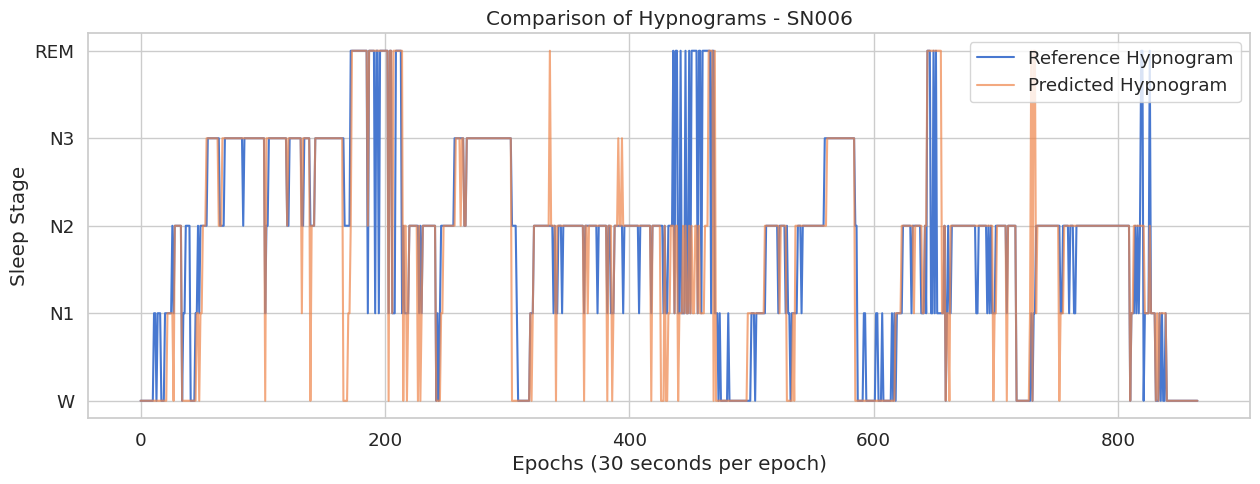


Accuracy per Sleep Stage:
Accuracy for W: 91.67%
Accuracy for N1: 36.60%
Accuracy for N2: 85.71%
Accuracy for N3: 96.39%
Accuracy for REM: 64.62%

N3 Stage Statistical Measures:
Sensitivity (Recall): 96.39%
Specificity: 98.57%
Precision: 94.12%
F1-Score: 95.24%
Extracting EDF parameters from /home/santiago/Desktop/BCI_UNL_AllisonPeterson_course-main/final_course_project/data/SN005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7370751  =      0.000 ... 28791.996 secs...


/tmp/ipykernel_235677/3500611535.py:29: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
/home/santiago/Desktop/BCI_UNL_AllisonPeterson_course-main/final_course_project/.venv/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(



Dataset: SN005
Overall Accuracy: 79.14%


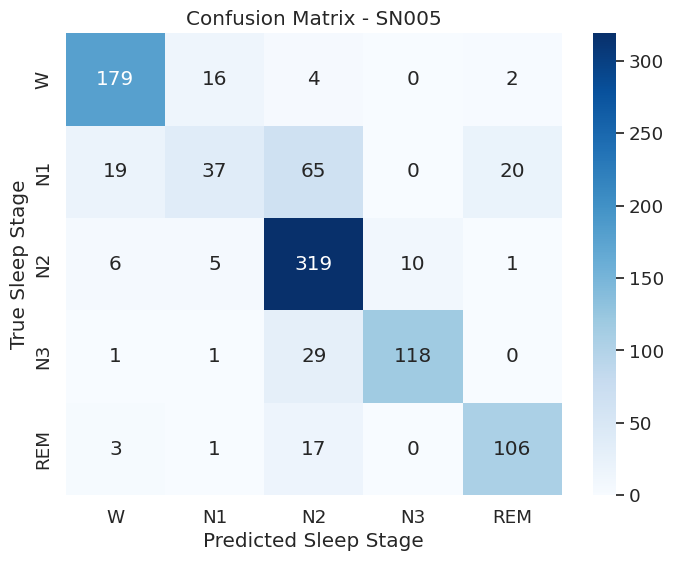

Classification Report:
              precision    recall  f1-score   support

           W       0.86      0.89      0.88       201
          N1       0.62      0.26      0.37       141
          N2       0.74      0.94      0.82       341
          N3       0.92      0.79      0.85       149
         REM       0.82      0.83      0.83       127

    accuracy                           0.79       959
   macro avg       0.79      0.74      0.75       959
weighted avg       0.78      0.79      0.77       959

Cohen's Kappa: 0.720


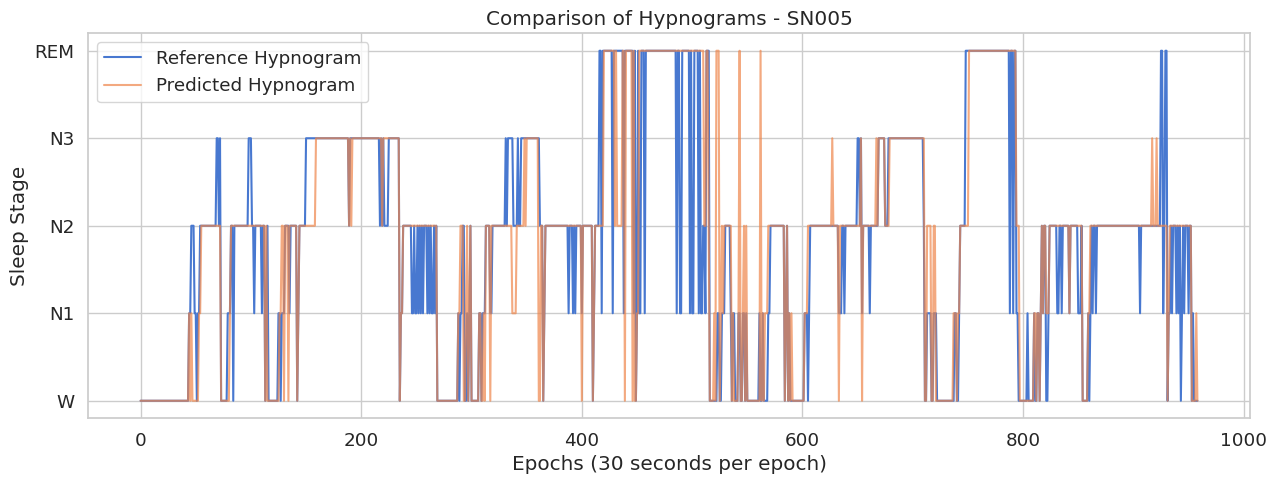


Accuracy per Sleep Stage:
Accuracy for W: 89.05%
Accuracy for N1: 26.24%
Accuracy for N2: 93.55%
Accuracy for N3: 79.19%
Accuracy for REM: 83.46%

N3 Stage Statistical Measures:
Sensitivity (Recall): 79.19%
Specificity: 98.77%
Precision: 92.19%
F1-Score: 85.20%


In [6]:
# List of dataset identifiers
datasets = ['SN001', 'SN002', 'SN003', 'SN006', 'SN005']

# Initialize lists to collect overall metrics and confidence intervals
accuracies = []
n3_accuracies = []
kappas = []
kappa_cis = []
dataset_names = []

# Loop over each dataset
for dataset in datasets:
    # Define file paths
    annotations_file = f'data/{dataset}_sleepscoring.txt'
    edf_file = f'data/{dataset}.edf'

    # Check if files exist
    if not os.path.exists(annotations_file):
        print(f'Annotations file not found for {dataset}. Skipping.')
        continue
    if not os.path.exists(edf_file):
        print(f'EDF file not found for {dataset}. Skipping.')
        continue

    # Load annotations
    hypno_ref = load_annotations(annotations_file)

    # Load PSG data using MNE
    raw = mne.io.read_raw_edf(edf_file, preload=True)

    # Predict sleep stages using YASA
    hypno_pred_int = predict_sleep_stages(raw)

    # Align the lengths
    len_ref = len(hypno_ref)
    len_pred = len(hypno_pred_int)

    if len_pred > len_ref:
        hypno_pred_int = hypno_pred_int[:len_ref]
    elif len_ref > len_pred:
        hypno_ref = hypno_ref[:len_pred]

    # Perform the analysis and collect metrics
    accuracy, kappa, n3_accuracy, conf_mat, labels = perform_analysis(hypno_ref, hypno_pred_int, dataset_name=dataset)
    

    # Calculate Cohen's Kappa with confidence intervals
    kappa, kappa_ci = kappa_with_confidence(hypno_ref, hypno_pred_int)

    # Append metrics to lists
    accuracies.append(accuracy)
    n3_accuracies.append(n3_accuracy)
    kappas.append(kappa)
    kappa_cis.append(kappa_ci)
    dataset_names.append(dataset)



Summary of Performance Metrics Across Datasets:
  Dataset  Overall Accuracy (%)  Cohen's Kappa  N3 Accuracy (%)  \
0   SN001             81.264637       0.721096         8.695652   
1   SN002             80.140187       0.738243        91.071429   
2   SN003             73.480084       0.656824        60.666667   
3   SN006             78.406467       0.707889        96.385542   
4   SN005             79.144943       0.720393        79.194631   

   Kappa CI Lower  Kappa CI Upper  
0        0.682179        0.761782  
1        0.703644        0.773240  
2        0.624489        0.689841  
3        0.674388        0.745320  
4        0.687866        0.754754  


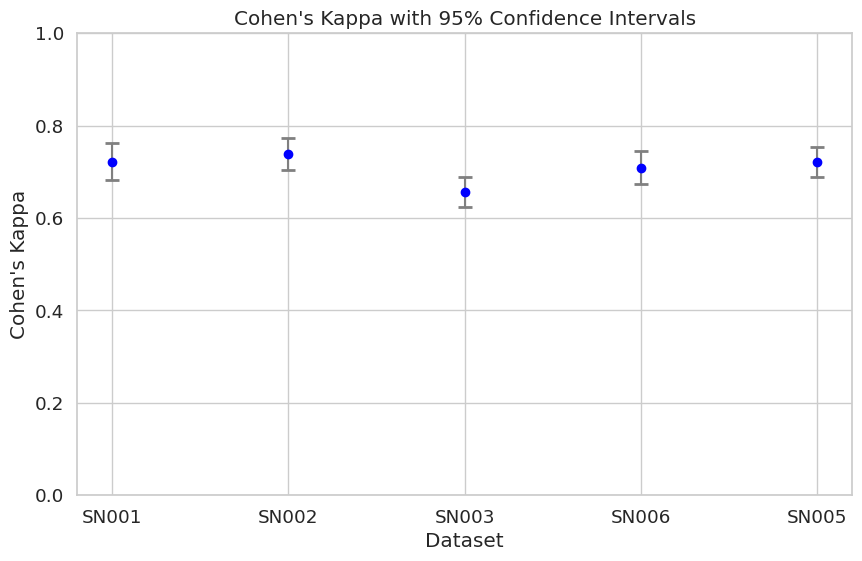

In [7]:
# Add confidence intervals to the summary DataFrame
summary_df = pd.DataFrame({
    'Dataset': dataset_names,
    'Overall Accuracy (%)': [acc * 100 for acc in accuracies],
    "Cohen's Kappa": kappas,
    'N3 Accuracy (%)': [acc * 100 for acc in n3_accuracies],
    "Kappa CI Lower": [ci[0] for ci in kappa_cis],
    "Kappa CI Upper": [ci[1] for ci in kappa_cis]
})

print('\nSummary of Performance Metrics Across Datasets:')
print(summary_df)

# Plot Cohen's Kappa with error bars representing confidence intervals
plt.figure(figsize=(10, 6))
plt.errorbar(summary_df['Dataset'], summary_df["Cohen's Kappa"],
             yerr=[summary_df["Cohen's Kappa"] - summary_df["Kappa CI Lower"],
                   summary_df["Kappa CI Upper"] - summary_df["Cohen's Kappa"]],
             fmt='o', capsize=5, capthick=2, color='blue', ecolor='gray')
plt.title("Cohen's Kappa with 95% Confidence Intervals")
plt.ylabel("Cohen's Kappa")
plt.xlabel("Dataset")
plt.ylim(0, 1)
plt.grid(True)
plt.show()


Extracting EDF parameters from /home/santiago/Desktop/BCI_UNL_AllisonPeterson_course-main/final_course_project/data/SN001.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6566399  =      0.000 ... 25649.996 secs...


/tmp/ipykernel_235677/3105039377.py:56: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
/tmp/ipykernel_235677/3105039377.py:56: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
/home/santiago/Desktop/BCI_UNL_AllisonPeterson_course-main/final_course_project/.venv/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/tmp/ipykernel_235677/3105039377.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign 

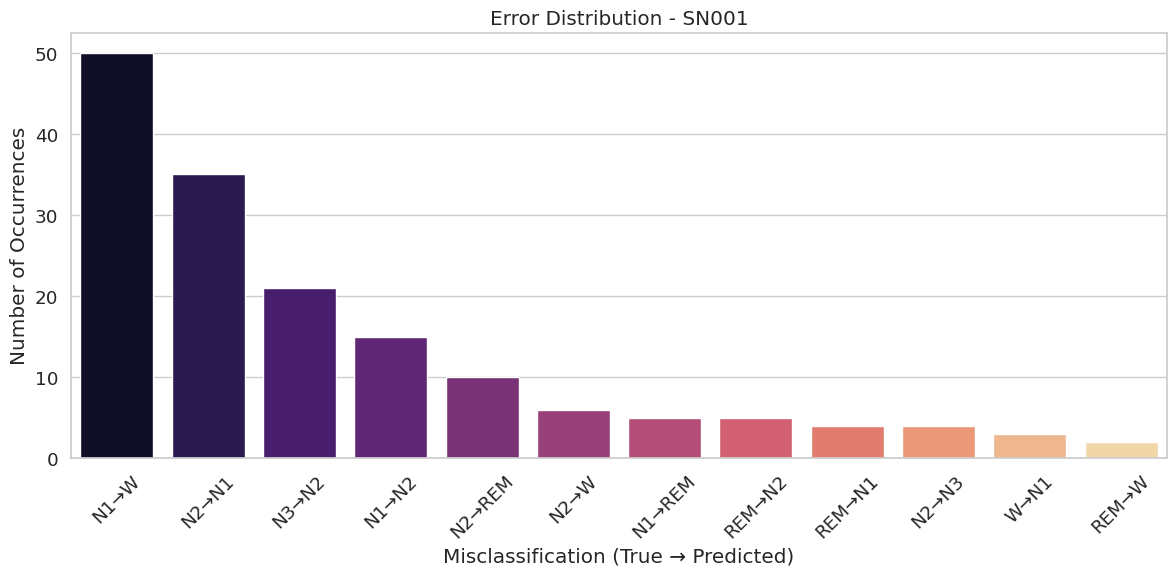

Extracting EDF parameters from /home/santiago/Desktop/BCI_UNL_AllisonPeterson_course-main/final_course_project/data/SN002.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6577407  =      0.000 ... 25692.996 secs...


/tmp/ipykernel_235677/3105039377.py:56: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
/tmp/ipykernel_235677/3105039377.py:56: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
/home/santiago/Desktop/BCI_UNL_AllisonPeterson_course-main/final_course_project/.venv/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/tmp/ipykernel_235677/3105039377.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign 

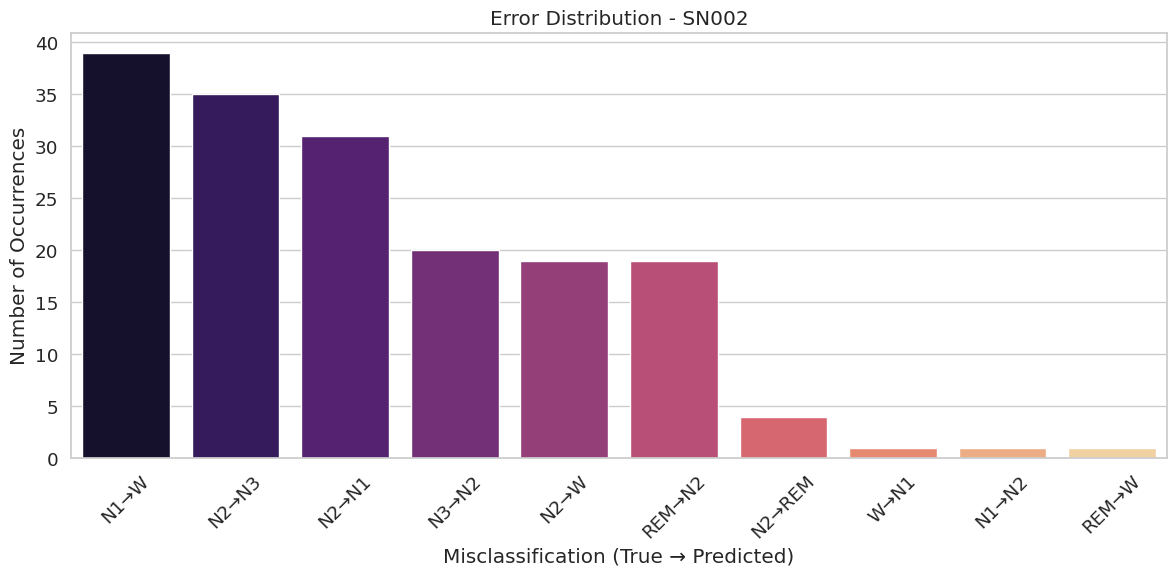

Extracting EDF parameters from /home/santiago/Desktop/BCI_UNL_AllisonPeterson_course-main/final_course_project/data/SN003.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7330815  =      0.000 ... 28635.996 secs...


/tmp/ipykernel_235677/3105039377.py:56: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
/tmp/ipykernel_235677/3105039377.py:56: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
/home/santiago/Desktop/BCI_UNL_AllisonPeterson_course-main/final_course_project/.venv/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/tmp/ipykernel_235677/3105039377.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign 

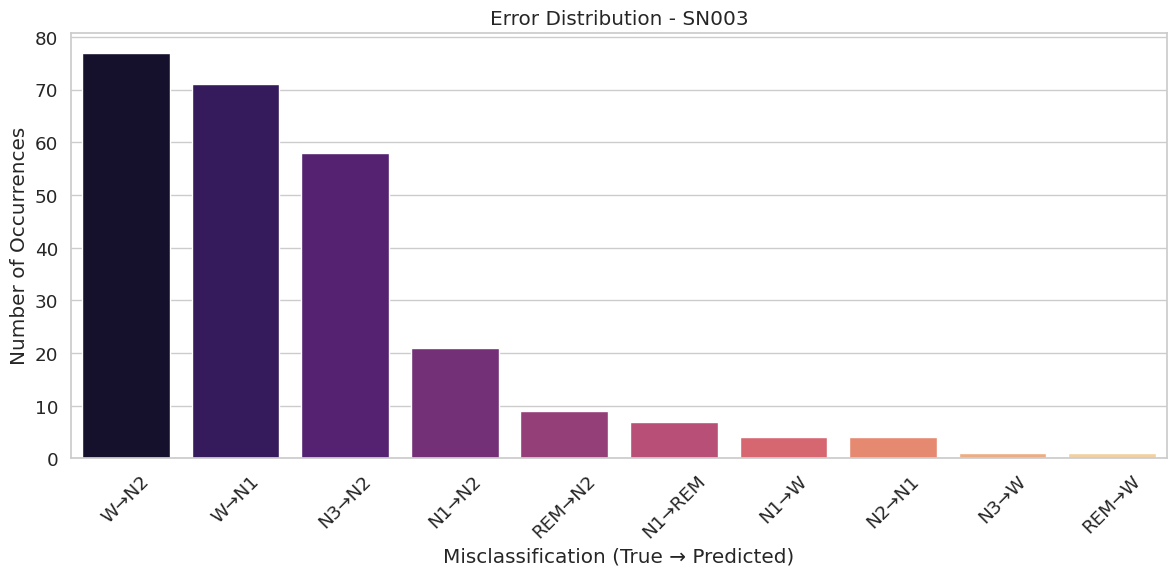

Extracting EDF parameters from /home/santiago/Desktop/BCI_UNL_AllisonPeterson_course-main/final_course_project/data/SN006.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 6655487  =      0.000 ... 25997.996 secs...


/tmp/ipykernel_235677/3105039377.py:56: RuntimeWarning: Channels contain different highpass filters. Highest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
/tmp/ipykernel_235677/3105039377.py:56: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
/home/santiago/Desktop/BCI_UNL_AllisonPeterson_course-main/final_course_project/.venv/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/tmp/ipykernel_235677/3105039377.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign 

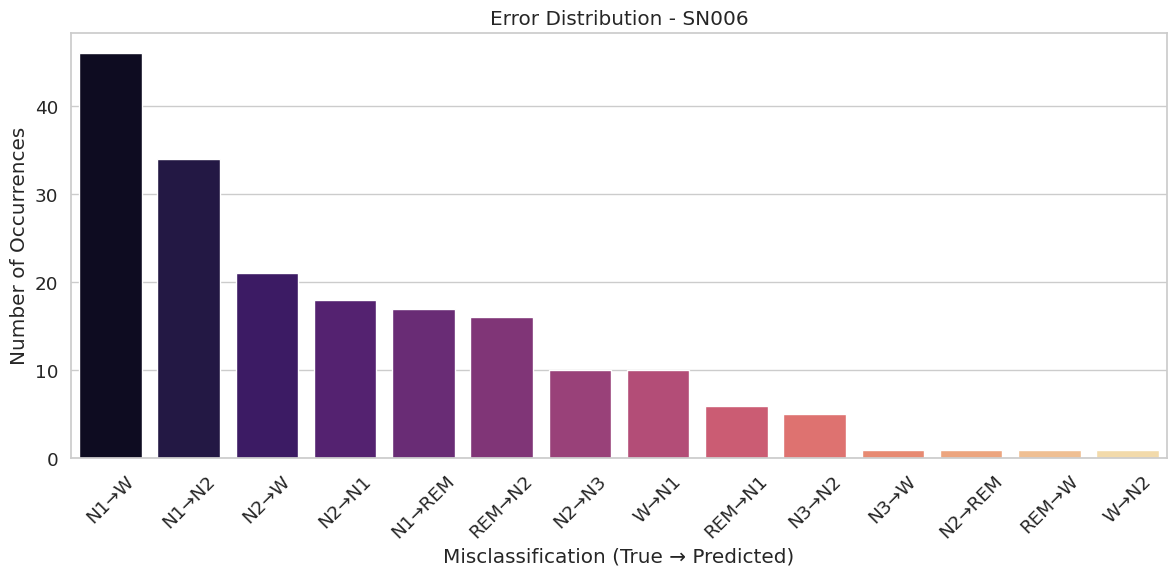

Extracting EDF parameters from /home/santiago/Desktop/BCI_UNL_AllisonPeterson_course-main/final_course_project/data/SN005.edf...
EDF file detected
Setting channel info structure...
Creating raw.info structure...
Reading 0 ... 7370751  =      0.000 ... 28791.996 secs...


/tmp/ipykernel_235677/3105039377.py:56: RuntimeWarning: Channels contain different lowpass filters. Lowest filter setting will be stored.
  raw = mne.io.read_raw_edf(edf_file, preload=True)
/home/santiago/Desktop/BCI_UNL_AllisonPeterson_course-main/final_course_project/.venv/lib/python3.9/site-packages/sklearn/base.py:376: InconsistentVersionWarning: Trying to unpickle estimator LabelEncoder from version 0.24.2 when using version 1.5.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
/tmp/ipykernel_235677/3105039377.py:25: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Misclassification', y='Count', data=error_df, palette='magma')


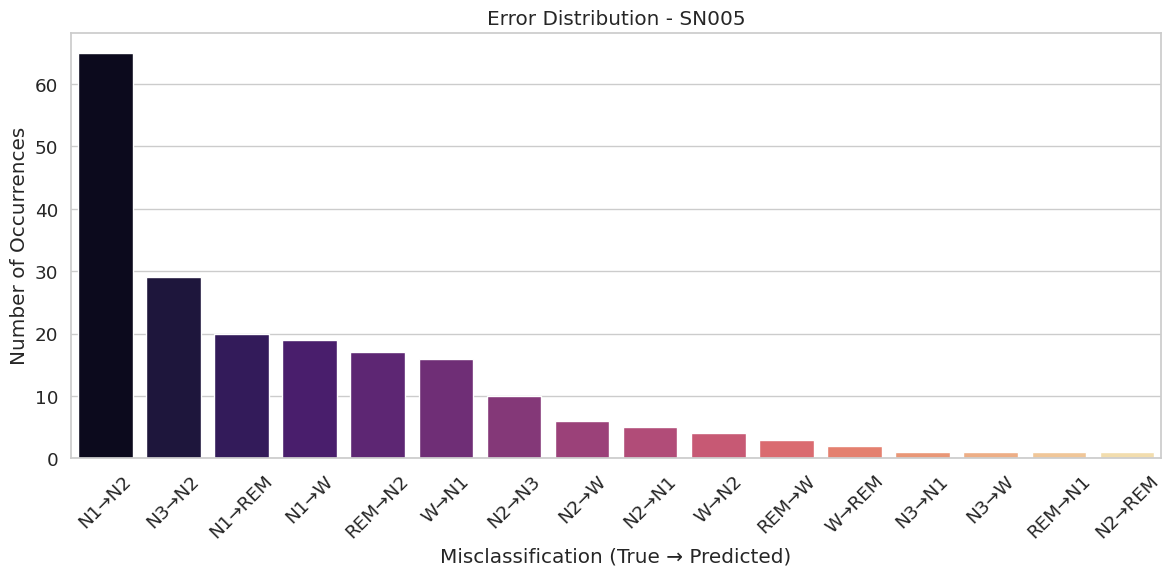

In [8]:
def plot_error_distribution(hypno_ref, hypno_pred_int, dataset_name):
    """
    Plot the distribution of misclassifications for each sleep stage.
    """
    # Map sleep stage integers to labels
    stage_dict = {0: 'W', 1: 'N1', 2: 'N2', 3: 'N3', 4: 'REM'}
    
    # Identify misclassifications
    errors = [(stage_dict[true], stage_dict[pred]) for true, pred in zip(hypno_ref, hypno_pred_int) if true != pred]
    
    # Create error labels in the format 'True Stage → Predicted Stage'
    error_labels = [f'{true}→{pred}' for true, pred in errors]
    
    # Count the occurrences of each misclassification
    from collections import Counter
    error_counts = Counter(error_labels)
    
    # Create a DataFrame for plotting
    error_df = pd.DataFrame.from_dict(error_counts, orient='index').reset_index()
    error_df.columns = ['Misclassification', 'Count']
    error_df = error_df.sort_values('Count', ascending=False)
    
    # Plot
    plt.figure(figsize=(12, 6))
    sns.barplot(x='Misclassification', y='Count', data=error_df, palette='magma')
    plt.title(f'Error Distribution - {dataset_name}')
    plt.xticks(rotation=45)
    plt.ylabel('Number of Occurrences')
    plt.xlabel('Misclassification (True → Predicted)')
    plt.tight_layout()
    plt.show()

# Call the function within the main loop
for dataset in datasets:
    # Define file paths
    annotations_file = f'data/{dataset}_sleepscoring.txt'
    edf_file = f'data/{dataset}.edf'
    # Loop over each dataset
for dataset in datasets:
    # Define file paths
    annotations_file = f'data/{dataset}_sleepscoring.txt'
    edf_file = f'data/{dataset}.edf'

    # Check if files exist
    if not os.path.exists(annotations_file):
        print(f'Annotations file not found for {dataset}. Skipping.')
        continue
    if not os.path.exists(edf_file):
        print(f'EDF file not found for {dataset}. Skipping.')
        continue

    # Load annotations
    hypno_ref = load_annotations(annotations_file)

    # Load PSG data using MNE
    raw = mne.io.read_raw_edf(edf_file, preload=True)

    # Predict sleep stages using YASA
    hypno_pred_int = predict_sleep_stages(raw)

    # ... [rest of the main loop] ...
    # Plot error distribution
    plot_error_distribution(hypno_ref, hypno_pred_int, dataset_name=dataset)


In [9]:
mean_kappa = np.mean(kappas)
std_kappa = np.std(kappas)

print(f"Mean Cohen's Kappa: {mean_kappa:.3f}")
print(f"Standard Deviation of Cohen's Kappa: {std_kappa:.3f}")


Mean Cohen's Kappa: 0.709
Standard Deviation of Cohen's Kappa: 0.028


In [10]:
mean_n3_sensitivity = np.mean([calculate_n3_statistics(confusion_matrix(hypno_ref, hypno_pred_int, labels=[0,1,2,3,4]), ['W', 'N1', 'N2', 'N3', 'REM'])['Sensitivity (Recall)'] for hypno_ref, hypno_pred_int in zip([hypno_ref], [hypno_pred_int])])
std_n3_sensitivity = np.std([calculate_n3_statistics(confusion_matrix(hypno_ref, hypno_pred_int, labels=[0,1,2,3,4]), ['W', 'N1', 'N2', 'N3', 'REM'])['Sensitivity (Recall)'] for hypno_ref, hypno_pred_int in zip([hypno_ref], [hypno_pred_int])])

print(f"Mean N3 Sensitivity (Recall): {mean_n3_sensitivity * 100:.2f}%")
print(f"Standard Deviation of N3 Sensitivity: {std_n3_sensitivity * 100:.2f}%")


Mean N3 Sensitivity (Recall): 79.19%
Standard Deviation of N3 Sensitivity: 0.00%


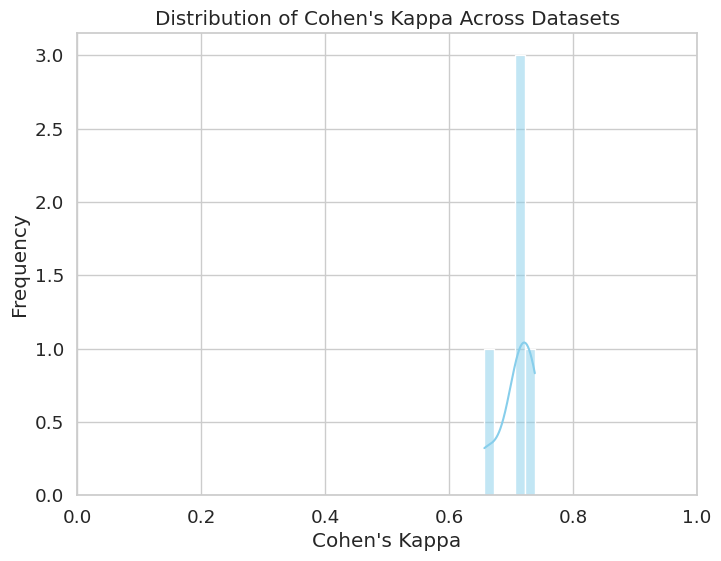

In [11]:
plt.figure(figsize=(8, 6))
sns.histplot(kappas, bins=5, kde=True, color='skyblue')
plt.title("Distribution of Cohen's Kappa Across Datasets")
plt.xlabel("Cohen's Kappa")
plt.ylabel("Frequency")
plt.xlim(0, 1)
plt.grid(True)
plt.show()



Summary of Performance Metrics Across Datasets:
  Dataset  Overall Accuracy (%)  Cohen's Kappa  N3 Accuracy (%)
0   SN001             81.264637       0.721096         8.695652
1   SN002             80.140187       0.738243        91.071429
2   SN003             73.480084       0.656824        60.666667
3   SN006             78.406467       0.707889        96.385542
4   SN005             79.144943       0.720393        79.194631


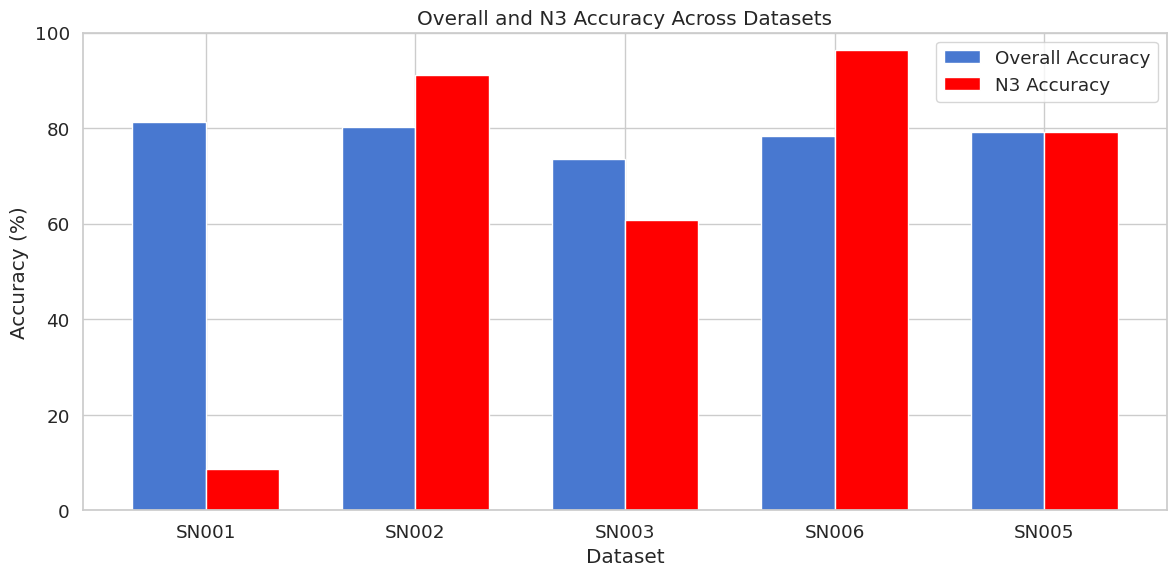

In [12]:
# Create a DataFrame to display the summary
summary_df = pd.DataFrame({
    'Dataset': dataset_names,
    'Overall Accuracy (%)': [acc * 100 for acc in accuracies],
    "Cohen's Kappa": kappas,
    'N3 Accuracy (%)': [acc * 100 for acc in n3_accuracies]
})

print('\nSummary of Performance Metrics Across Datasets:')
print(summary_df)

# Plot the overall accuracy and N3 accuracy
plt.figure(figsize=(12, 6))
bar_width = 0.35
index = np.arange(len(dataset_names))

plt.bar(index, summary_df['Overall Accuracy (%)'], bar_width, label='Overall Accuracy')
plt.bar(index + bar_width, summary_df['N3 Accuracy (%)'], bar_width, label='N3 Accuracy', color='red')

plt.xlabel('Dataset')
plt.ylabel('Accuracy (%)')
plt.title('Overall and N3 Accuracy Across Datasets')
plt.xticks(index + bar_width / 2, dataset_names)
plt.ylim(0, 100)
plt.legend()
plt.tight_layout()
plt.show()


Text(0.5, 1.0, "Cohen's Kappa Across Datasets")

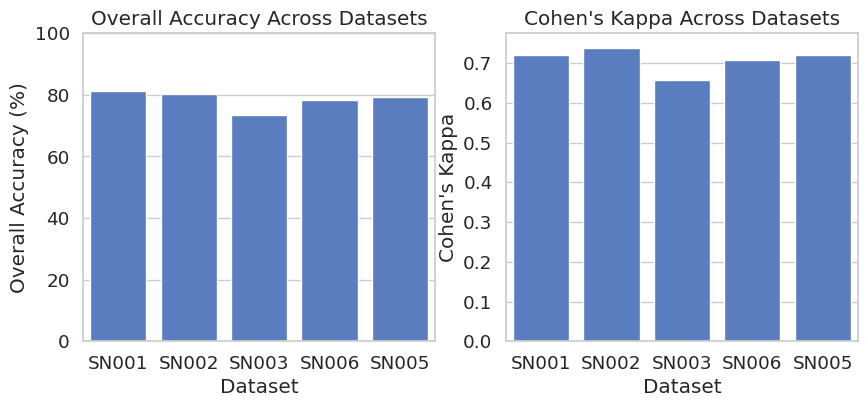

In [13]:
# Plot the overall accuracy and Cohen's Kappa
plt.figure(figsize=(10, 4))
plt.subplot(1, 2, 1)
sns.barplot(x='Dataset', y='Overall Accuracy (%)', data=summary_df)
plt.title('Overall Accuracy Across Datasets')
plt.ylim(0, 100)
plt.subplot(1, 2, 2)
sns.barplot(x='Dataset', y="Cohen's Kappa", data=summary_df)
plt.title("Cohen's Kappa Across Datasets")


/tmp/ipykernel_235677/2952643743.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Dataset', y="Cohen's Kappa", data=summary_df, palette='viridis')


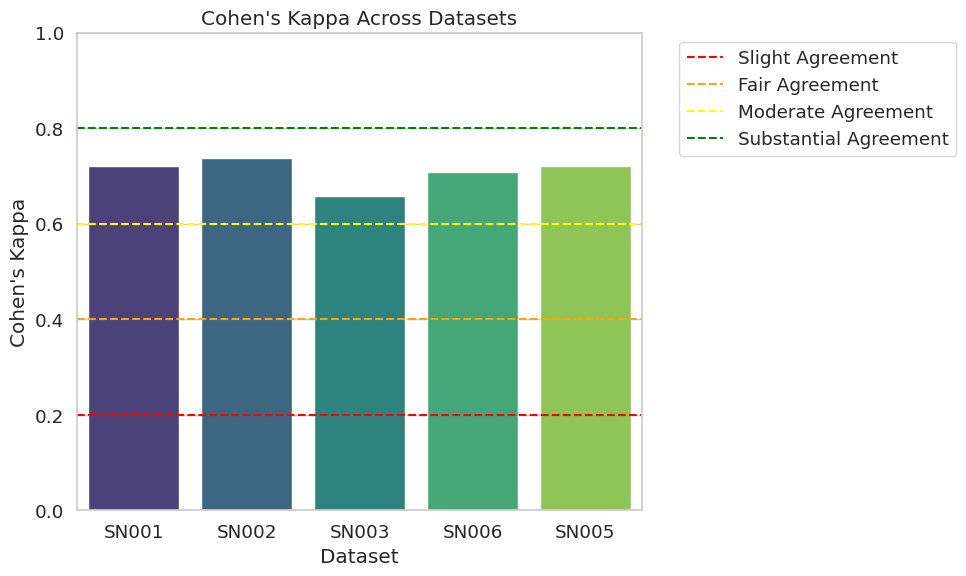

In [14]:
# Plot the Cohen's Kappa across datasets with interpretation thresholds
plt.figure(figsize=(10, 6))
sns.barplot(x='Dataset', y="Cohen's Kappa", data=summary_df, palette='viridis')
plt.title("Cohen's Kappa Across Datasets")
plt.ylabel("Cohen's Kappa")
plt.xlabel("Dataset")
plt.ylim(0, 1)

# Add horizontal lines for interpretation thresholds
plt.axhline(0.20, color='red', linestyle='--', label='Slight Agreement')
plt.axhline(0.40, color='orange', linestyle='--', label='Fair Agreement')
plt.axhline(0.60, color='yellow', linestyle='--', label='Moderate Agreement')
plt.axhline(0.80, color='green', linestyle='--', label='Substantial Agreement')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()


In [15]:
# Interpretation based on Landis and Koch (1977)
def interpret_kappa(kappa):
    if kappa < 0:
        return 'Poor'
    elif kappa < 0.20:
        return 'Slight'
    elif kappa < 0.40:
        return 'Fair'
    elif kappa < 0.60:
        return 'Moderate'
    elif kappa < 0.80:
        return 'Substantial'
    else:
        return 'Almost Perfect'

summary_df['Kappa Interpretation'] = summary_df["Cohen's Kappa"].apply(interpret_kappa)
print(summary_df[['Dataset', "Cohen's Kappa", 'Kappa Interpretation']])


  Dataset  Cohen's Kappa Kappa Interpretation
0   SN001       0.721096          Substantial
1   SN002       0.738243          Substantial
2   SN003       0.656824          Substantial
3   SN006       0.707889          Substantial
4   SN005       0.720393          Substantial
